# 2D Occlusion

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/26<br>
**Last modified:** 2021/03/07<br>
**Description:** How to obtain a class activation heatmap for an image classification model.

Adapted from Deep Learning with Python (2017).
## Setup

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 448 kB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=9b331e0d760725a404f9a1d42d5a4e57d1a76d51dcdf1e791775db1ad906f21e
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Lime
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import random

# inspired by
# https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb

## Configurable parameters

You can change these to another model.

To get the values for `last_conv_layer_name` use `model.summary()`
to see the names of all layers in the model.

In [ ]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
img_path = keras.utils.get_file(
    "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
)

# display(Image(img_path))


4227072/4217496 [==============================] - 0s 0us/step


## Use of Lime 

In [ ]:
# Make model
model = model_builder(weights="imagenet")

91897856/91884032 [==============================] - 1s 0us/step


In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [ ]:
# Overview of image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

print("array shape: ", img_array.shape)

preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=5)[0])

array shape:  (1, 299, 299, 3)
49152/35363 [=========================================] - 0s 0us/step
Predicted: [('n02504458', 'African_elephant', 0.8871446), ('n01871265', 'tusker', 0.05058822), ('n02504013', 'Indian_elephant', 0.011148933), ('n02172182', 'dung_beetle', 0.00029058155), ('n02391049', 'zebra', 0.0002699783)]


In [ ]:
# 101 tusker
# 385 indian elephant
# 386 african elephant
preds[0, 386]
# 283 persian cat

0.8871446

In [ ]:
explainer = lime_image.LimeImageExplainer(random_state=42)
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(img_array[0].astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
def plot_explanation(label, num_feat = 10):
  f, axs = plt.subplots(1, 4, figsize=(24,8))
  (ax1, ax2, ax3, ax4) = axs

  # temp1, mask1 = explanation.get_image_and_mask(label, positive_only=False, num_features=100, hide_rest=False)
  ax1.imshow((img_array[0]+1)/2)

  temp2, mask2 = explanation.get_image_and_mask(label, positive_only=False, num_features=num_feat, hide_rest=False)
  ax2.imshow(mark_boundaries(temp2 / 2 + 0.5, mask2))

  dict_heatmap = dict(explanation.local_exp[label])
  heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

  temp3, mask3 = explanation.get_image_and_mask(label, positive_only=True, num_features=num_feat, hide_rest=False)
  ax3.imshow(mark_boundaries(temp3 / 2 + 0.5, mask3))
  im = ax3.imshow(heatmap, cmap = 'jet', vmin  = heatmap.min(), vmax = heatmap.max(), alpha = 0.6)

  ax4.imshow(heatmap, cmap = 'jet', vmin  = heatmap.min(), vmax = heatmap.max())
  
  cb = f.colorbar(im, ax=axs.ravel().tolist())

# picture 2: red = prediction better if concealed
# picture 3 & 4: red = predicion worse if concealed

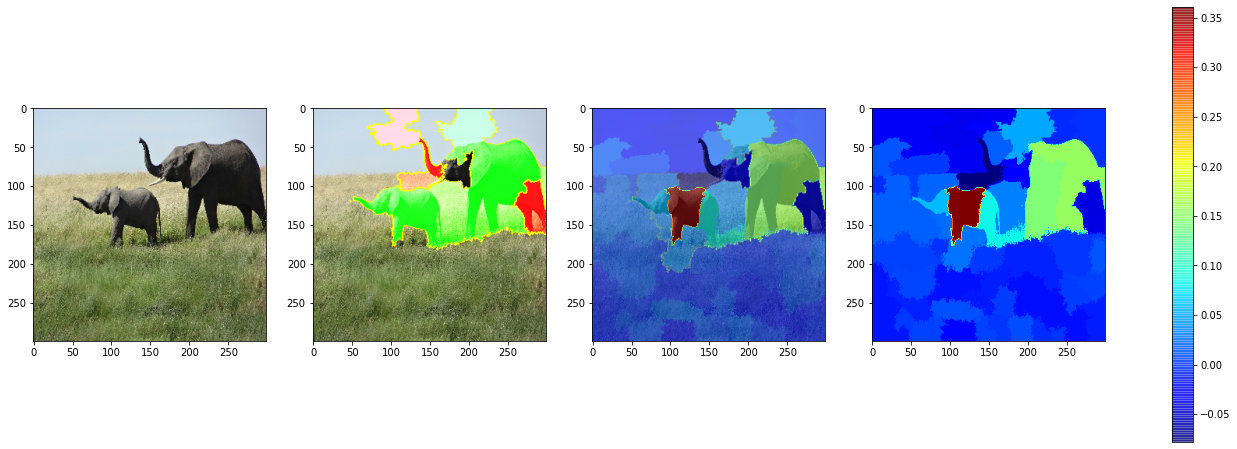

In [ ]:
plot_explanation(explanation.top_labels[0]) # african elephant

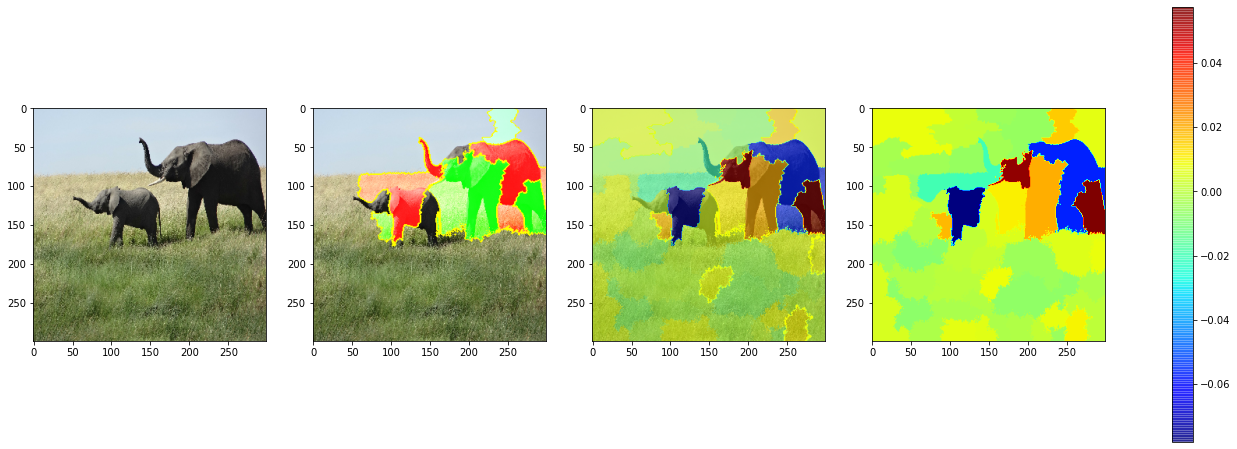

In [ ]:
plot_explanation(101) # tusker

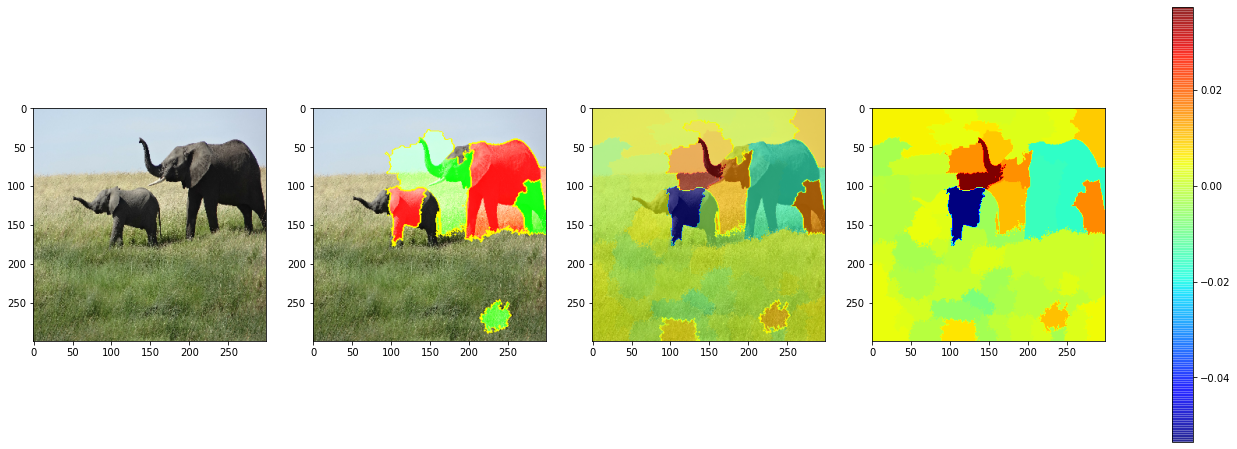

In [ ]:
plot_explanation(385) # indian elephant